In [14]:
#IMPORTS

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate
from scipy.optimize import curve_fit

In [44]:
#HARDCODED VALUES
R_URANUS = 25559 #at 1bar level (i.e. surface) (equatorial) in km
MAX_HEIGHT_ATM = 200 #in km
N_RES = 1000

/tmp/ipykernel_460074/2481156439.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x - d * x**2)
/tmp/ipykernel_460074/2481156439.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(decay_func, r, spl(r))


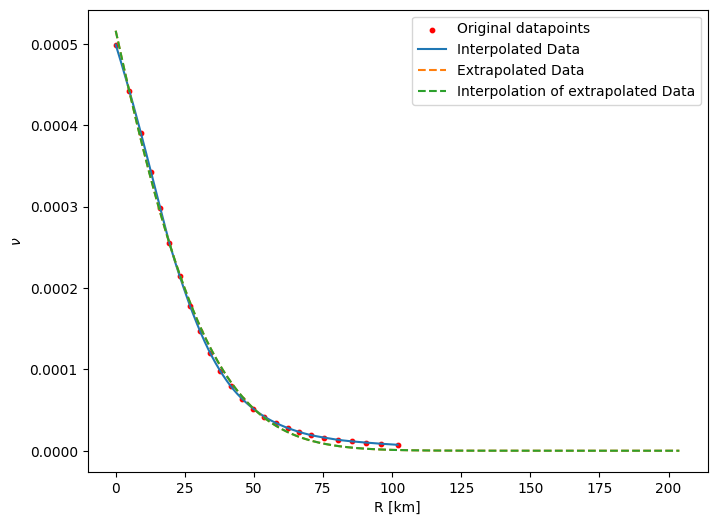

In [45]:
#Atmosphere nu values in 1D, interpolation and extrapolation on atmosphere and above


#generate data for interpolation
data = np.loadtxt("uranus_profile_default.csv", delimiter=',')
R_datapoints = data[:, 1]
nu_datapoints = data[:, 4]
spl = CubicSpline(R_datapoints, nu_datapoints)

r = np.linspace(np.min(R_datapoints), np.max(R_datapoints), 1000)

def decay_func(x, a, b, c, d):
    return a * np.exp(-b * x - d * x**2)

# Fit the curve to find optimal parameters
params, _ = curve_fit(decay_func, r, spl(r))

x_extrap = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 1000)
y_extrap = decay_func(x_extrap, *params)

r2 = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 5000)
spl2 = CubicSpline(x_extrap, y_extrap)

plt.figure(figsize=(8, 6))
plt.scatter(R_datapoints, nu_datapoints, s=10, c='r', label='Original datapoints')
plt.plot(r, spl(r), label='Interpolated Data')
plt.plot(x_extrap, y_extrap, label='Extrapolated Data', linestyle='dashed')
plt.plot(r2, spl2(r2), label='Interpolation of extrapolated Data', linestyle='dashed')

plt.xlabel('R [km]')
plt.ylabel(r'$\nu$')
plt.legend()
plt.show()



-1.5522766764022983e-05
0.0005161563593972594


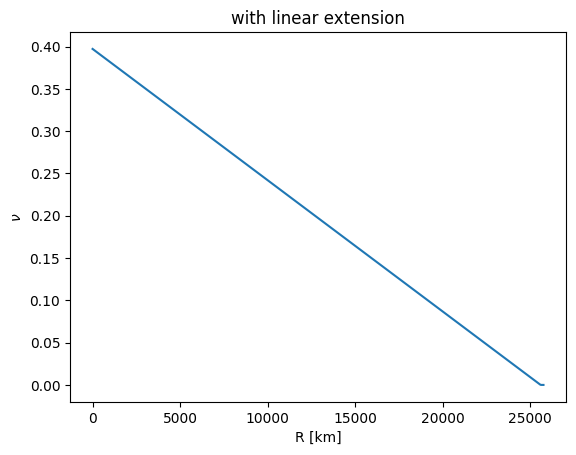

/tmp/ipykernel_460074/3758029787.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


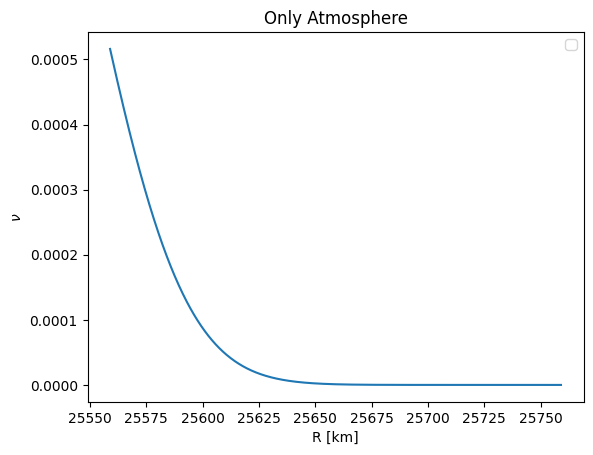

In [46]:
#extend atmophere nu values inside planet (linearly extended)
r2_min = np.min(r2)
spl2_min = spl2(r2_min)

# Use the slope at the end of the data (e.g., derivative of spl2 at r2_min)
slope = spl2.derivative()(r2_min)

# Create new r2 values lower than the minimum r2 value
r2_extrapolated = np.linspace(0, R_URANUS, 100)  # adjust range as needed

# Linear extrapolation formula
spl2_extrapolated = spl2_min + slope * (r2_extrapolated - r2_min)
print(slope)
print(spl2_min)

def calc_nu_from_r(r):
    if r < R_URANUS:
        return spl2_min + slope * (r - R_URANUS)
    else:
        return spl2(r - R_URANUS)



r_tot = np.linspace(0, R_URANUS + 200, 1000)
nu_values_tot = [calc_nu_from_r(value) for value in r_tot]
plt.plot(r_tot, nu_values_tot)
plt.xlabel("R [km]")
plt.ylabel(r'$\nu$')
plt.title("with linear extension")
plt.show()

r_atm = np.linspace(R_URANUS, R_URANUS + 200, 1000)
nu_values_atm = [calc_nu_from_r(value) for value in r_atm]
plt.plot(r_atm, nu_values_atm)

plt.legend()
plt.xlabel("R [km]")
plt.ylabel(r'$\nu$')
plt.title("Only Atmosphere")
plt.show()

In [47]:

def calc_r(s, b):
    '''
    Calculates the distance to the center of the planet.
    Input values:
    s: path variable (-inf initially, 0 when passing the planet, infinity at the end)
    b: impact parameter
    '''
    return np.sqrt(s**2 + b**2)


def calc_nu(s, b):

    r = calc_r(s, b)

    if r < R_URANUS:
        #return 0
        return spl2_min + slope * (r - R_URANUS)
    
    elif (r > R_URANUS + 2*np.max(R_datapoints)):
        return 0

    else:
        return spl2(r - R_URANUS)



def calc_los(b):
    '''
    Calculates the line-of-sight integral
    Input values:
    b: Impact parameter
    '''
    if b < R_URANUS:
         return -5
    else:    
        return integrate.quad(lambda s: calc_nu(s, b), -np.inf, np.inf)[0]

#Have to start from R_URANUS
calc_los(R_URANUS + 20)
'''np.linspace(R_URANUS, R_URANUS + MAX_HEIGHT_ATM, 5000)
los_values = [calc_los(value) for value in r]
plt.plot(
r = r, los_values)
plt.xlabel("Radius [km]")
plt.ylabel(r'optical path diffenrence [km]')
#plt.xlim(0, 1000)
'''

'np.linspace(R_URANUS, R_URANUS + MAX_HEIGHT_ATM, 5000)\nlos_values = [calc_los(value) for value in r]\nplt.plot(\nr = r, los_values)\nplt.xlabel("Radius [km]")\nplt.ylabel(r\'optical path diffenrence [km]\')\n#plt.xlim(0, 1000)\n'

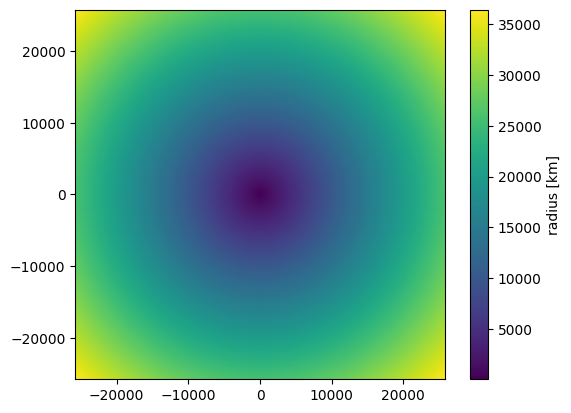

/tmp/ipykernel_460074/3923878065.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda s: calc_nu(s, b), -np.inf, np.inf)[0]


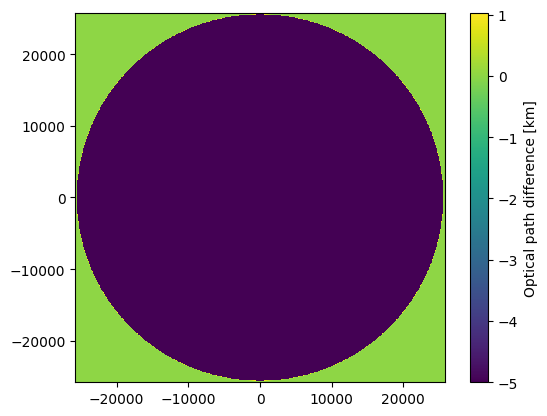

In [ ]:
#Setup variables
x = np.linspace(-R_URANUS - MAX_HEIGHT_ATM, R_URANUS + MAX_HEIGHT_ATM, N_RES)
y = np.linspace(-R_URANUS - MAX_HEIGHT_ATM, R_URANUS + MAX_HEIGHT_ATM, N_RES)

#Setup meshgrid
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)

plt.pcolormesh(X, Y, R)
cbar1 = plt.colorbar()
cbar1.set_label("radius [km]")
plt.gca().set_aspect('equal')
plt.show()

vectorized_calc_los = np.vectorize(calc_los)
result = vectorized_calc_los(R)


#result is the important meshgrid


plt.pcolormesh(X, Y, result)
cbar2 = plt.colorbar()
cbar2.set_label("Optical path difference [km]")
plt.gca().set_aspect('equal')

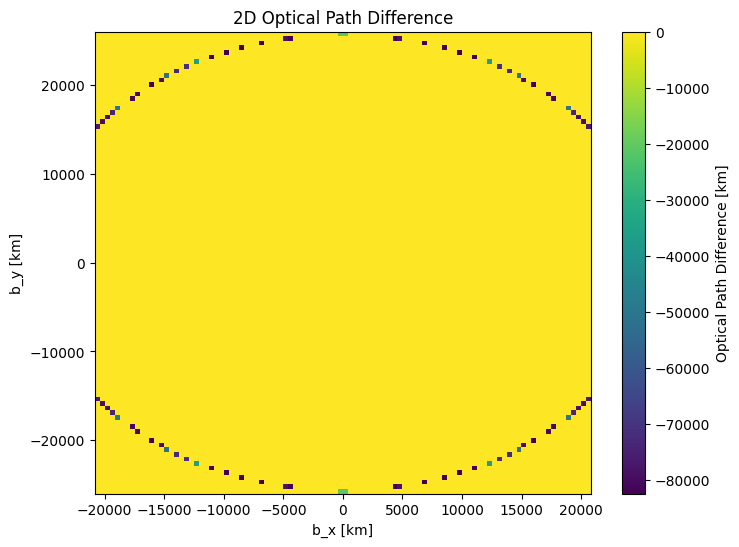

In [ ]:
b_max = R_URANUS + MAX_HEIGHT_ATM
b_x = np.linspace(-b_max * 0.8, b_max * 0.8, N_RES)
b_y = np.linspace(-b_max, b_max, N_RES)
B_X, B_Y = np.meshgrid(b_x, b_y)
B = np.sqrt(B_X**2 + B_Y**2)

# Compute LOS values for the grid
los_grid = np.vectorize(calc_los)(B)

# Plot the result using pcolormesh
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(B_X, B_Y, los_grid, shading='auto', cmap='viridis')
plt.colorbar(c, label='Optical Path Difference [km]')
plt.xlabel("b_x [km]")
plt.ylabel("b_y [km]")
plt.title("2D Optical Path Difference")
plt.show()


#atmosphere is different at different lattitude
#

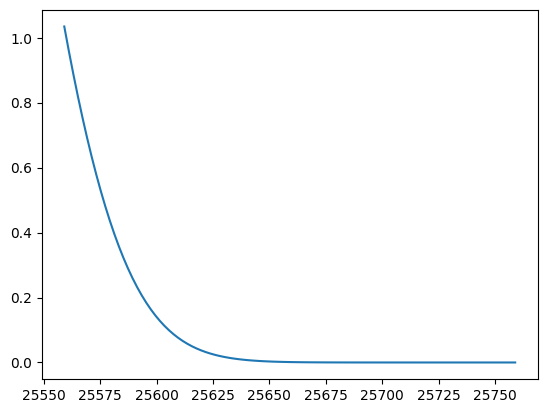

In [21]:

def calc_r(s, b):
    '''
    Calculates the distance to the center of the planet.
    Input values:
    s: path variable (-inf initially, 0 when passing the planet, infinity at the end)
    b: impact parameter
    '''
    return np.sqrt(s**2 + b**2)


def calc_nu(s, b):
    r = calc_r(s, b)
    if (r < R_URANUS):
        
        raise ValueError("Radius hits Planet's surface.")
    
    elif (r > R_URANUS + 2*np.max(R_datapoints)):
        return 0
    
    else:
        return spl2(r - R_URANUS)


def calc_los(b):
    '''
    Calculates the line-of-sight integral
    Input values:
    b: Impact parameter
    '''
    return integrate.quad(lambda s: calc_nu(s, b), -np.inf, np.inf)[0]

#Have to start from R_URANUS
calc_los(R_URANUS + 20)

r = np.linspace(R_URANUS, R_URANUS + MAX_HEIGHT_ATM, 100)
los_values = [calc_los(value) for value in r]
plt.plot(r, los_values)
